## **Forward Pass Summary**

In [1]:
!pip install nnfs

from google.colab import drive

# Connect Google Drive
drive.mount('/content/drive')

# Move to folder
import os
os.chdir('/content/drive/My Drive/lecture_05')
print("Current Directory:", os.getcwd())


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Current Directory: /content/drive/My Drive/lecture_05


In [2]:
import numpy as np
import nnfs
from nnfs.datasets import spiral_data
import matplotlib.pyplot as plt

import pandas as pd

from sklearn.preprocessing import StandardScaler # Deal with categorical data
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

import tensorflow as tf
import torch
import torch.nn as nn # Neural Networks
import torch.nn.functional as F
import torch.optim as optim # Optimizers
from torch.utils.data import Dataset, DataLoader

In [3]:
nnfs.init() # Load the data

In [4]:
# Forward Pass

class Layer_Dense:

    # Layer initialization
    def __init__(self, n_inputs, n_neurons):
        # Initialize weights and biases
        self.weights = 0.01 * np.random.randn(n_inputs, n_neurons)
        self.biases = np.zeros((1, n_neurons))

    # Forward pass
    def forward(self, inputs):
        # Calculate output values from inputs, weights and biases
        self.output = np.dot(inputs, self.weights) + self.biases

In [5]:
# Activation Functions

class Activation_ReLU:

    # Forward pass
    def forward(self, inputs):
        # Calculate output values from inputs
        self.output = np.maximum(0, inputs)

class Activation_Softmax:

    # Forward pass
    def forward(self, inputs):

        # Get unnormalized probabilities
        exp_values = np.exp(inputs - np.max(inputs, axis=1,
                                            keepdims=True))
        # Normalize them for each sample
        probabilities = exp_values / np.sum(exp_values, axis=1,
                                            keepdims=True)

        self.output = probabilities

In [6]:
# Compute the Loss with softmax

# Common loss class
class Loss:

    # Calculates the data and regularization losses
    # given model output and ground truth values
    def calculate(self, output, y):

        # Calculate sample losses
        sample_losses = self.forward(output, y)


        # Calculate mean loss
        data_loss = np.mean(sample_losses)

        # Return loss
        return data_loss

class Loss_CategoricalCrossentropy(Loss):

    # Forward pass
    def forward(self, y_pred, y_true):

        # Number of samples in a batch
        samples = len(y_pred)

        # Clip data to prevent division by 0
        # Clip both sides to not drag mean towards any value
        y_pred_clipped = np.clip(y_pred, 1e-7, 1 - 1e-7)


        # Probabilities for target values -
        # only if categorical labels
        if len(y_true.shape) == 1:
            correct_confidences = y_pred_clipped[
                range(samples),
                y_true
            ]

        # Mask values - only for one-hot encoded labels
        elif len(y_true.shape) == 2:
            correct_confidences = np.sum(
                y_pred_clipped*y_true,
                axis=1
            )

        # Losses
        negative_log_likelihoods = -np.log(correct_confidences)
        return negative_log_likelihoods

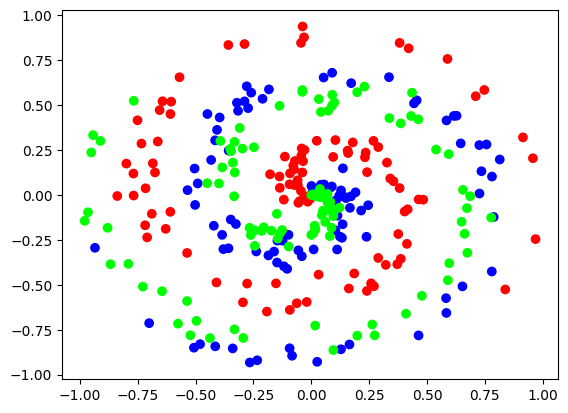

In [7]:

# Create dataset
X, y = spiral_data(samples=100, classes=3)

plt.scatter(X[:,0], X[:,1], c=y, cmap = 'brg')
plt.show()
# print(X)
# print(y)

In [8]:
# Create Dense layer with 2 input features and 3 output values
dense1 = Layer_Dense(2, 3)

# Create ReLU activation (to be used with Dense layer):
activation1 = Activation_ReLU()

# Create second Dense layer with 3 input features (as we take output
# of previous layer here) and 3 output values
dense2 = Layer_Dense(3, 3)

# Create Softmax activation (to be used with Dense layer):
activation2 = Activation_Softmax()

# Create loss function
loss_function = Loss_CategoricalCrossentropy()

# Perform a forward pass of our training data through this layer
dense1.forward(X)

# Perform a forward pass through activation function
# it takes the output of first dense layer here
activation1.forward(dense1.output)


# Perform a forward pass through second Dense layer
# it takes outputs of activation function of first layer as inputs
dense2.forward(activation1.output)

# Perform a forward pass through activation function
# it takes the output of second dense layer here
activation2.forward(dense2.output)

# Let's see output of the first few samples:
print(activation2.output[:10])

# Perform a forward pass through loss function
# it takes the output of second dense layer here and returns loss
loss = loss_function.calculate(activation2.output, y)

# Print loss value
print('loss:', loss)

[[0.33333334 0.33333334 0.33333334]
 [0.3333332  0.3333332  0.33333364]
 [0.3333329  0.33333293 0.3333342 ]
 [0.3333326  0.33333263 0.33333477]
 [0.33333233 0.3333324  0.33333528]
 [0.33333284 0.33333287 0.3333343 ]
 [0.33333182 0.3333319  0.33333626]
 [0.3333318  0.3333319  0.33333623]
 [0.3333315  0.3333316  0.33333692]
 [0.33333105 0.3333312  0.33333772]]
loss: 1.0986104


In [9]:
# Accuracy is easier to interpret

predictions = activation2.output
predictions = np.argmax(predictions, axis=1)
accuracy = np.mean(predictions==y)
print('accuracy:', accuracy)

accuracy: 0.34


## **Calculus Recap**

In this section, we revisit essential concepts from calculus that form the foundation of gradient-based optimization techniques in neural networks. Specifically, we will cover **partial derivatives**, the **gradient**, and the **chain rule**. These tools are crucial for understanding and implementing the backpropagation algorithm, which enables neural networks to learn from data.

---

### **Partial Derivatives**

Partial derivatives are a generalization of ordinary derivatives to functions of multiple variables. When a function $f(x_1, x_2, \dots, x_n)$ depends on several variables, the partial derivative with respect to one of these variables measures how $f$ changes when that specific variable changes, while all other variables remain constant.

The partial derivative of $f$ with respect to $x_i$ is denoted as:

$$
\frac{\partial f}{\partial x_i}
$$

For example, if $f(x, y) = x^2 + 3xy + y^2$, the partial derivatives are:

$$
\frac{\partial f}{\partial x} = 2x + 3y, \quad \frac{\partial f}{\partial y} = 3x + 2y
$$

---

### **The Gradient**

The gradient of a scalar function $f(x_1, x_2, \dots, x_n)$ is a vector that points in the direction of the steepest ascent of $f$. It is composed of all the partial derivatives of $f$ with respect to its variables:

$$
\nabla f = \begin{bmatrix}
\frac{\partial f}{\partial x_1} \\
\frac{\partial f}{\partial x_2} \\
\vdots \\
\frac{\partial f}{\partial x_n}
\end{bmatrix}
$$

For the same example $f(x, y) = x^2 + 3xy + y^2$, the gradient is:

$$
\nabla f = \begin{bmatrix}
\frac{\partial f}{\partial x} \\
\frac{\partial f}{\partial y}
\end{bmatrix} =
\begin{bmatrix}
2x + 3y \\
3x + 2y
\end{bmatrix}
$$

The gradient is a key concept in gradient descent, as it guides us in updating parameters to minimize a given loss function.

---

### **The Chain Rule**

The chain rule allows us to compute the derivative of a composite function. If $z$ depends on $y$, and $y$ depends on $x$, then the rate of change of $z$ with respect to $x$ can be found using:

$$
\frac{dz}{dx} = \frac{dz}{dy} \cdot \frac{dy}{dx}
$$

In the context of partial derivatives, if $f$ is a function of $u_1, u_2, \dots, u_m$, and each $u_i$ is a function of $x_1, x_2, \dots, x_n$, the chain rule is expressed as:

$$
\frac{\partial f}{\partial x_j} = \sum_{i=1}^m \frac{\partial f}{\partial u_i} \cdot \frac{\partial u_i}{\partial x_j}
$$

The chain rule is particularly important in neural networks for calculating gradients through layers of non-linear transformations.

---

By combining these concepts—partial derivatives, gradients, and the chain rule—we can derive the mathematical framework for **gradient descent**, the algorithm that enables neural networks to optimize their parameters and learn from data.


# **Lecture 5: Backpropagation**

Now that we understand how to measure the impact of variables on a function’s output, we can begin writing code to calculate partial derivatives and analyze their role in minimizing the model’s loss. To simplify the process, we’ll start by backpropagating the ReLU function for a single neuron, treating it as a demonstration exercise before applying it to a full neural network. The goal is to use the chain rule with derivatives and partial derivatives to understand how each variable affects the ReLU output, laying the groundwork for minimizing the overall loss later.

In [10]:
# Consider a simple neuron with 2 inputs

x = [1.0, -2.0]
w = [3.0, -1.0]
b = 1

for i in range(len(x)):
    print(f"Output {i+1}: {x[i]*w[i]}")

Output 1: 3.0
Output 2: 2.0


In [11]:
# Completting the forward pass

total = 0
for i in range(len(x)):
    total += x[i]*w[i]
total += b
print(total)

6.0


In [12]:
# ReLU activation function
output = max(total,0)
print(output)

6.0


![Neural Network](nn.png)

### Chain Rule

The chain rule is used to differentiate composite functions. If you have a function \( y = f(g(x)) \), the derivative is given by:

$$
\frac{d}{dx} f(g(x)) = f'(g(x)) \cdot g'(x)
$$

In our example:

$$
\begin{aligned}
f(x) &= \text{ReLU}(x), \\
g(x) &= x_1 \cdot w_1 + x_1 \cdot w_2 + x_1 \cdot w_3 + b, \\
\implies f(g(x)) &= \text{ReLU}(x_1 \cdot w_1 + x_1 \cdot w_2 + x_1 \cdot w_3 + b)
\end{aligned}
$$

The derivative of ReLU is given by:

$$
\begin{aligned}
f(x) &= \text{max}(x, 0), \\
\implies \frac{d}{dx}f(x) &= 1 \quad (x > 0), \\
&= 0 \quad (x \leq 0)
\end{aligned}
$$







In [13]:
# In python

relu_d = (1. if total > 0 else 0.)
print(total)

6.0


![ReLU Diagram](relud.png)


### Chain Rule

The chain rule is used to differentiate composite functions. If you have a function \( y = f(g(x)) \), the derivative is given by:

$$
\frac{d}{dx} f(g(x)) = f'(g(x)) \cdot g'(x)
$$

In our example:

$$
\begin{aligned}
f(x) &= \text{ReLU}(x), \\
g(x) &= x_1 \cdot w_1 + x_1 \cdot w_2 + x_1 \cdot w_3 + b, \\
\implies f(g(x)) &= \text{ReLU}(x_1 \cdot w_1 + x_1 \cdot w_2 + x_1 \cdot w_3 + b)
\end{aligned}
$$

The derivative of ReLU is given by:

$$
\begin{aligned}
f(x) &= \text{max}(x, 0), \\
\implies \frac{d}{dx}f(x) &= 1 \quad (x > 0), \\
&= 0 \quad (x \leq 0)
\end{aligned}
$$

### Gradient Descent

In optimization, gradient descent is a method used to minimize a function iteratively. Given a loss function $ L(w) $, the weight updates are given by:

$$
w = w - \eta \cdot \nabla_w L(w)
$$

where:
- $ w $ is the weight,
- $ \eta $ is the learning rate,
- $ \nabla_w L(w) $ is the gradient of the loss function with respect to the weights.

For our example, the gradient of the loss with respect to the weights can be computed using the chain rule:

$$
\nabla_w L(w) = \frac{\partial L}{\partial f(g(x))} \cdot \frac{\partial f(g(x))}{\partial g(x)} \cdot \frac{\partial g(x)}{\partial w}
$$

Using the chain rule, we propagate the gradients backward from the output to the weights. In this case, the derivative of $ f(g(x)) $ with respect to $ g(x) $ depends on the ReLU function, and the derivative of $ g(x) $ with respect to $ w_1 $ is simply $ x_1 $.

Thus, the weight update rule becomes:

$$
w_1 = w_1 - \eta \cdot \frac{\partial L}{\partial f(g(x))} \cdot \frac{\partial f(g(x))}{\partial g(x)} \cdot x_1
$$

### Gradient Descent for Each Weight Component

Now, let's break down how the gradient descent works for each individual weight component $( w_1 ,  w_2 ,  w_3 )$.

- **For \( w_1 \):**
  The partial derivative of $ g(x) $ with respect to $ w_1 $ is $ x_1 $. So, the weight update rule for $ w_1 $ becomes:

  $$
  w_1 = w_1 - \eta \cdot \frac{\partial L}{\partial f(g(x))} \cdot \frac{\partial f(g(x))}{\partial g(x)} \cdot x_1
  $$

- **For \( w_2 \):**
  Similarly, the partial derivative of \( g(x) \) with respect to \( w_2 \) is \( x_2 \). Thus, the weight update rule for \( w_2 \) is:

  $$
  w_2 = w_2 - \eta \cdot \frac{\partial L}{\partial f(g(x))} \cdot \frac{\partial f(g(x))}{\partial g(x)} \cdot x_2
  $$

- **For \( w_3 \):**
  The partial derivative of \( g(x) \) with respect to \( w_3 \) is \( x_3 \). So the weight update rule for \( w_3 \) is:

  $$
  w_3 = w_3 - \eta \cdot \frac{\partial L}{\partial f(g(x))} \cdot \frac{\partial f(g(x))}{\partial g(x)} \cdot x_3
  $$

### Summary

The gradient descent updates each weight $ w_1 $, $ w_2 $, and $ w_3 $. The updates depend on the gradient of the loss with respect to the output of the ReLU function, which is propagated through the chain rule. The learning rate $ \eta $ controls how large the weight updates are in each iteration.



In [14]:
pd.set_option('display.max_columns', None) # Visualize all columns

In [15]:
# We will stary by loading our kaggle data set

data_path = "./kaggle/train.csv" # This is the path where the data is located
data = pd.read_csv(data_path)
data

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,Ex,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,NaN,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,Ex,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,Ex,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,NaN,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,Gd,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,Ex,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,1456,60,RL,62.0,7917,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,6,5,1999,2000,Gable,CompShg,VinylSd,VinylSd,NaN,0.0,TA,TA,PConc,Gd,TA,No,Unf,0,Unf,0,953,953,GasA,Ex,Y,SBrkr,953,694,0,1647,0,0,2,1,3,1,TA,7,Typ,1,TA,Attchd,1999.0,RFn,2,460,TA,TA,Y,0,40,0,0,0,0,NaN,NaN,NaN,0,8,2007,WD,Normal,175000
1456,1457,20,RL,85.0,13175,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,NWAmes,Norm,Norm,1Fam,1Story,6,6,1978,1988,Gable,CompShg,Plywood,Plywood,Stone,119.0,TA,TA,CBlock,Gd,TA,No,ALQ,790,Rec,163,589,1542,GasA,TA,Y,SBrkr,2073,0,0,2073,1,0,2,0,3,1,TA,7,Min1,2,TA,Attchd,1978.0,Unf,2,500,TA,TA,Y,349,0,0,0,0,0,NaN,MnPrv,NaN,0,2,2010,WD,Normal,210000
1457,1458,70,RL,66.0,9042,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,9,1941,2006,Gable,CompShg,CemntBd,CmentBd,NaN,0.0,Ex,Gd,Stone,TA,Gd,No,GLQ,275,Unf,0,877,1152,GasA,Ex,Y,SBrkr,1188,1152,0,2340,0,0,2,0,4,1,Gd,9,Typ,2,Gd,Attchd,1941.0,RFn,1,252,TA,TA,Y,0,60,0,0,0,0,NaN,GdPrv,Shed,2500,5,2010,WD,Normal,266500
1458,1459,20,RL,68.0,9717,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Norm,Norm,1Fam,1Story,5,6,1950,1996,Hip,CompShg,MetalSd,MetalSd,NaN,0.0,TA,TA,CBlock,TA,TA,Mn,GLQ,49,Rec,1029,0,1078,GasA,Gd,

In [16]:
# data.info()

In [17]:
data = data.drop('Id', axis=1)

In [18]:
def onehot_encode(data, column, prefix=None):
    """
    One-hot encodes a specified column in the dataset.

    Parameters:
        data (pd.DataFrame): The input dataframe.
        column (str): The name of the column to encode.
        prefix (str, optional): The prefix for one-hot encoded column names. Defaults to the column name.

    Returns:
        pd.DataFrame: A dataframe with the specified column one-hot encoded.
    """
    data = data.copy()
    if prefix is None:
        prefix = column
    dummies = pd.get_dummies(data[column], prefix=prefix)
    data = pd.concat([data, dummies], axis=1)
    data = data.drop(column, axis=1)
    return data

In [19]:
# Identify non-numeric columns
non_numeric_cols = data.select_dtypes(include=['object']).columns

# Apply one-hot encoding to all non-numeric columns
for col in non_numeric_cols:
    data = onehot_encode(data, col, None)

# Display the updated datasetdata.head())
data.head()

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice,MSZoning_C (all),MSZoning_FV,MSZoning_RH,MSZoning_RL,MSZoning_RM,Street_Grvl,Street_Pave,Alley_Grvl,Alley_Pave,LotShape_IR1,LotShape_IR2,LotShape_IR3,LotShape_Reg,LandContour_Bnk,LandContour_HLS,LandContour_Low,LandContour_Lvl,Utilities_AllPub,Utilities_NoSeWa,LotConfig_Corner,LotConfig_CulDSac,LotConfig_FR2,LotConfig_FR3,LotConfig_Inside,LandSlope_Gtl,LandSlope_Mod,LandSlope_Sev,Neighborhood_Blmngtn,Neighborhood_Blueste,Neighborhood_BrDale,Neighborhood_BrkSide,Neighborhood_ClearCr,Neighborhood_CollgCr,Neighborhood_Crawfor,Neighborhood_Edwards,Neighborhood_Gilbert,Neighborhood_IDOTRR,Neighborhood_MeadowV,Neighborhood_Mitchel,Neighborhood_NAmes,Neighborhood_NPkVill,Neighborhood_NWAmes,Neighborhood_NoRidge,Neighborhood_NridgHt,Neighborhood_OldTown,Neighborhood_SWISU,Neighborhood_Sawyer,Neighborhood_SawyerW,Neighborhood_Somerst,Neighborhood_StoneBr,Neighborhood_Timber,Neighborhood_Veenker,Condition1_Artery,Condition1_Feedr,Condition1_Norm,Condition1_PosA,Condition1_PosN,Condition1_RRAe,Condition1_RRAn,Condition1_RRNe,Condition1_RRNn,Condition2_Artery,Condition2_Feedr,Condition2_Norm,Condition2_PosA,Condition2_PosN,Condition2_RRAe,Condition2_RRAn,Condition2_RRNn,BldgType_1Fam,BldgType_2fmCon,BldgType_Duplex,BldgType_Twnhs,BldgType_TwnhsE,HouseStyle_1.5Fin,HouseStyle_1.5Unf,HouseStyle_1Story,HouseStyle_2.5Fin,HouseStyle_2.5Unf,HouseStyle_2Story,HouseStyle_SFoyer,HouseStyle_SLvl,RoofStyle_Flat,RoofStyle_Gable,RoofStyle_Gambrel,RoofStyle_Hip,RoofStyle_Mansard,RoofStyle_Shed,RoofMatl_ClyTile,RoofMatl_CompShg,RoofMatl_Membran,RoofMatl_Metal,RoofMatl_Roll,RoofMatl_Tar&Grv,RoofMatl_WdShake,RoofMatl_WdShngl,Exterior1st_AsbShng,Exterior1st_AsphShn,Exterior1st_BrkComm,Exterior1st_BrkFace,Exterior1st_CBlock,Exterior1st_CemntBd,Exterior1st_HdBoard,Exterior1st_ImStucc,Exterior1st_MetalSd,Exterior1st_Plywood,Exterior1st_Stone,Exterior1st_Stucco,Exterior1st_VinylSd,Exterior1st_Wd Sdng,Exterior1st_WdShing,Exterior2nd_AsbShng,Exterior2nd_AsphShn,Exterior2nd_Brk Cmn,Exterior2nd_BrkFace,Exterior2nd_CBlock,Exterior2nd_CmentBd,Exterior2nd_HdBoard,Exterior2nd_ImStucc,Exterior2nd_MetalSd,Exterior2nd_Other,Exterior2nd_Plywood,Exterior2nd_Stone,Exterior2nd_Stucco,Exterior2nd_VinylSd,Exterior2nd_Wd Sdng,Exterior2nd_Wd Shng,MasVnrType_BrkCmn,MasVnrType_BrkFace,MasVnrType_Stone,ExterQual_Ex,ExterQual_Fa,ExterQual_Gd,ExterQual_TA,ExterCond_Ex,ExterCond_Fa,ExterCond_Gd,ExterCond_Po,ExterCond_TA,Foundation_BrkTil,Foundation_CBlock,Foundation_PConc,Foundation_Slab,Foundation_Stone,Foundation_Wood,BsmtQual_Ex,BsmtQual_Fa,BsmtQual_Gd,BsmtQual_TA,BsmtCond_Fa,BsmtCond_Gd,BsmtCond_Po,BsmtCond_TA,BsmtExposure_Av,BsmtExposure_Gd,BsmtExposure_Mn,BsmtExposure_No,BsmtFinType1_ALQ,BsmtFinType1_BLQ,BsmtFinType1_GLQ,BsmtFinType1_LwQ,BsmtFinType1_Rec,BsmtFinType1_Unf,BsmtFinType2_ALQ,BsmtFinType2_BLQ,BsmtFinType2_GLQ,BsmtFinType2_LwQ,BsmtFinType2_Rec,BsmtFinType2_Unf,Heating_Floor,Heating_GasA,Heating_GasW,Heating_Grav,Heating_OthW,Heating_Wall,HeatingQC_Ex,HeatingQC_Fa,HeatingQC_Gd,HeatingQC_Po,HeatingQC_TA,CentralAir_N,CentralAir_Y,Electrical_FuseA,Electrical_FuseF,Electrical_FuseP,Electrical_Mix,Electrical_SBrkr,KitchenQual_Ex,KitchenQual_Fa,KitchenQual_Gd,KitchenQual_TA,Functional_Maj1,Functional_Maj2,Functional_Min1,Functional_Min2,Functional_Mod,Functional_Sev,Functional_Typ,FireplaceQu_Ex,FireplaceQu_Fa,FireplaceQu_Gd,FireplaceQu_Po,FireplaceQu_TA,GarageType_2Types,GarageType_Attchd,GarageType_Basment,GarageType_BuiltIn,GarageType_CarPort,GarageType_Detchd,GarageFinish_Fin,GarageFinish_RFn,GarageFinish_Unf,GarageQual_Ex,GarageQual_Fa,GarageQual_Gd,GarageQual_Po,GarageQual_T

In [20]:
boolean_columns = data.select_dtypes(include=['bool']).columns
data[boolean_columns] = data[boolean_columns].astype(int)
data = data.dropna()
data.head()

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice,MSZoning_C (all),MSZoning_FV,MSZoning_RH,MSZoning_RL,MSZoning_RM,Street_Grvl,Street_Pave,Alley_Grvl,Alley_Pave,LotShape_IR1,LotShape_IR2,LotShape_IR3,LotShape_Reg,LandContour_Bnk,LandContour_HLS,LandContour_Low,LandContour_Lvl,Utilities_AllPub,Utilities_NoSeWa,LotConfig_Corner,LotConfig_CulDSac,LotConfig_FR2,LotConfig_FR3,LotConfig_Inside,LandSlope_Gtl,LandSlope_Mod,LandSlope_Sev,Neighborhood_Blmngtn,Neighborhood_Blueste,Neighborhood_BrDale,Neighborhood_BrkSide,Neighborhood_ClearCr,Neighborhood_CollgCr,Neighborhood_Crawfor,Neighborhood_Edwards,Neighborhood_Gilbert,Neighborhood_IDOTRR,Neighborhood_MeadowV,Neighborhood_Mitchel,Neighborhood_NAmes,Neighborhood_NPkVill,Neighborhood_NWAmes,Neighborhood_NoRidge,Neighborhood_NridgHt,Neighborhood_OldTown,Neighborhood_SWISU,Neighborhood_Sawyer,Neighborhood_SawyerW,Neighborhood_Somerst,Neighborhood_StoneBr,Neighborhood_Timber,Neighborhood_Veenker,Condition1_Artery,Condition1_Feedr,Condition1_Norm,Condition1_PosA,Condition1_PosN,Condition1_RRAe,Condition1_RRAn,Condition1_RRNe,Condition1_RRNn,Condition2_Artery,Condition2_Feedr,Condition2_Norm,Condition2_PosA,Condition2_PosN,Condition2_RRAe,Condition2_RRAn,Condition2_RRNn,BldgType_1Fam,BldgType_2fmCon,BldgType_Duplex,BldgType_Twnhs,BldgType_TwnhsE,HouseStyle_1.5Fin,HouseStyle_1.5Unf,HouseStyle_1Story,HouseStyle_2.5Fin,HouseStyle_2.5Unf,HouseStyle_2Story,HouseStyle_SFoyer,HouseStyle_SLvl,RoofStyle_Flat,RoofStyle_Gable,RoofStyle_Gambrel,RoofStyle_Hip,RoofStyle_Mansard,RoofStyle_Shed,RoofMatl_ClyTile,RoofMatl_CompShg,RoofMatl_Membran,RoofMatl_Metal,RoofMatl_Roll,RoofMatl_Tar&Grv,RoofMatl_WdShake,RoofMatl_WdShngl,Exterior1st_AsbShng,Exterior1st_AsphShn,Exterior1st_BrkComm,Exterior1st_BrkFace,Exterior1st_CBlock,Exterior1st_CemntBd,Exterior1st_HdBoard,Exterior1st_ImStucc,Exterior1st_MetalSd,Exterior1st_Plywood,Exterior1st_Stone,Exterior1st_Stucco,Exterior1st_VinylSd,Exterior1st_Wd Sdng,Exterior1st_WdShing,Exterior2nd_AsbShng,Exterior2nd_AsphShn,Exterior2nd_Brk Cmn,Exterior2nd_BrkFace,Exterior2nd_CBlock,Exterior2nd_CmentBd,Exterior2nd_HdBoard,Exterior2nd_ImStucc,Exterior2nd_MetalSd,Exterior2nd_Other,Exterior2nd_Plywood,Exterior2nd_Stone,Exterior2nd_Stucco,Exterior2nd_VinylSd,Exterior2nd_Wd Sdng,Exterior2nd_Wd Shng,MasVnrType_BrkCmn,MasVnrType_BrkFace,MasVnrType_Stone,ExterQual_Ex,ExterQual_Fa,ExterQual_Gd,ExterQual_TA,ExterCond_Ex,ExterCond_Fa,ExterCond_Gd,ExterCond_Po,ExterCond_TA,Foundation_BrkTil,Foundation_CBlock,Foundation_PConc,Foundation_Slab,Foundation_Stone,Foundation_Wood,BsmtQual_Ex,BsmtQual_Fa,BsmtQual_Gd,BsmtQual_TA,BsmtCond_Fa,BsmtCond_Gd,BsmtCond_Po,BsmtCond_TA,BsmtExposure_Av,BsmtExposure_Gd,BsmtExposure_Mn,BsmtExposure_No,BsmtFinType1_ALQ,BsmtFinType1_BLQ,BsmtFinType1_GLQ,BsmtFinType1_LwQ,BsmtFinType1_Rec,BsmtFinType1_Unf,BsmtFinType2_ALQ,BsmtFinType2_BLQ,BsmtFinType2_GLQ,BsmtFinType2_LwQ,BsmtFinType2_Rec,BsmtFinType2_Unf,Heating_Floor,Heating_GasA,Heating_GasW,Heating_Grav,Heating_OthW,Heating_Wall,HeatingQC_Ex,HeatingQC_Fa,HeatingQC_Gd,HeatingQC_Po,HeatingQC_TA,CentralAir_N,CentralAir_Y,Electrical_FuseA,Electrical_FuseF,Electrical_FuseP,Electrical_Mix,Electrical_SBrkr,KitchenQual_Ex,KitchenQual_Fa,KitchenQual_Gd,KitchenQual_TA,Functional_Maj1,Functional_Maj2,Functional_Min1,Functional_Min2,Functional_Mod,Functional_Sev,Functional_Typ,FireplaceQu_Ex,FireplaceQu_Fa,FireplaceQu_Gd,FireplaceQu_Po,FireplaceQu_TA,GarageType_2Types,GarageType_Attchd,GarageType_Basment,GarageType_BuiltIn,GarageType_CarPort,GarageType_Detchd,GarageFinish_Fin,GarageFinish_RFn,GarageFinish_Unf,GarageQual_Ex,GarageQual_Fa,GarageQual_Gd,GarageQual_Po,GarageQual_T

In [21]:
y = data['SalePrice']
X = data.drop('SalePrice', axis=1).copy()

In [22]:
scaler = StandardScaler()
X = scaler.fit_transform(X)

In [23]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = 0.7, random_state = 1)

# TensorFlow Implementation

In [24]:
X_train.shape

(784, 287)

In [25]:
inputs = tf.keras.Input(shape = (287,))
hidden = tf.keras.layers.Dense(512, activation='relu')(inputs)
hidden = tf.keras.layers.Dense(256, activation='relu')(hidden)
outputs = tf.keras.layers.Dense(1, activation='linear')(hidden)

tf_model = tf.keras.Model(inputs, outputs)

tf_model.compile(
    optimizer='adam',
    loss = 'mse',
    )

history = tf_model.fit(
    X_train,
    y_train,
    validation_split=0.12,
    batch_size=32,
    epochs=500
)

Epoch 1/500
22/22 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - loss: 44758003712.0000 - val_loss: 37573087232.0000
Epoch 2/500
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 44329488384.0000 - val_loss: 37476196352.0000
Epoch 3/500
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 44523859968.0000 - val_loss: 37168041984.0000
Epoch 4/500
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 40867475456.0000 - val_loss: 36452413440.0000
Epoch 5/500
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 39778271232.0000 - val_loss: 35126370304.0000
Epoch 6/500
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 41233186816.0000 - val_loss: 33014384640.0000
Epoch 7/500
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 32368359424.0000 - val_loss: 30210365440.0000
Epoch 8/500
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 30683086848.0000 - val_loss: 26688522240.0000
Epoch 9/500
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 25729277952.0000 - val_loss: 22970634240.0000
Epoch 10/500
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 17m

In [26]:
tf_rmse = np.sqrt(tf_model.evaluate(X_test, y_test))

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 2150419456.0000 


## Pytorch Implementation

In [27]:
class PricePrediction(nn.Module):
    def __init__(self):
        super(PricePrediction, self).__init__()
        self.layer1 = nn.Linear(287, 512)
        self.layer2 = nn.Linear(512, 256)
        self.output = nn.Linear(256, 1)

    def forward(self, x):
        x = F.relu(self.layer1(x))
        x = F.relu(self.layer2(x))
        x = self.output(x)
        return x

In [28]:
model = PricePrediction()

# Visualize all the weights
list(model.parameters())

for i in range(len(list(model.parameters()))):
    print(list(model.parameters())[i].shape)

torch.Size([512, 287])
torch.Size([512])
torch.Size([256, 512])
torch.Size([256])
torch.Size([1, 256])
torch.Size([1])


In [29]:
# Conver data to torch tensors

t_X_train = torch.tensor(X_train).type(torch.float32)
t_y_train = torch.tensor(np.array(y_train)).type(torch.float32)

t_X_test = torch.tensor(X_test).type(torch.float32)
t_y_test = torch.tensor(np.array(y_test)).type(torch.float32)

In [30]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.01) # Use the Adam Optimizer
criterion = nn.MSELoss() # Use MSE loss (one taught in class)

In [31]:
# Training

for x, target in zip(t_X_train, t_y_train):
    optimizer.zero_grad()
    output = model(x)
    loss = criterion(output, target)
    loss.backward()
    optimizer.step()

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


In [32]:
total_loss = 0

# Testing Model with validation data

for x, target in zip(t_X_test, t_y_test):
    output = model(x)
    loss = criterion(output, target)
    total_loss += loss

avg_loss = total_loss / len(t_X_test)

In [33]:
# Return RMSE to compare performance with TF

torch_rmse = torch.sqrt(avg_loss).detach().numpy()

In [34]:
print(np.sqrt(7206027915.6364))

84888.32614462603


In [35]:
print("TensorFlow RMSE:", tf_rmse)
print("PyTorch RMSE:", torch_rmse)

TensorFlow RMSE: 46193.33285226343
PyTorch RMSE: 73850.63


PyTorch performed better

---

### Question 1

Now it's your turn to implement a neural network! Using the provided **NNFS** dataset, create a simple neural network in both **PyTorch** and **TensorFlow** to perform a classification task. For this task, make sure to:

- Use **BCELoss** (Binary Cross-Entropy Loss) as your loss function.
- Apply the **Softmax** activation function in the output layer to normalize the predicted values into probabilities.

You can refer to the documentation for both libraries for more details on how to implement this. Try to compare the results between the two frameworks and see how they perform!


PyTorch Implementation

In [36]:
# Generate the dataset
X, y = spiral_data(samples=100, classes=2)

# Convert to PyTorch tensors
X = torch.tensor(X, dtype=torch.float32)
y = torch.tensor(y, dtype=torch.float32).reshape(-1, 1)  # reshape for BCELoss

# Split dataset into training (80%) and testing (20%)
X_train, X_test, y_train, y_test = train_test_split(X.numpy(), y.numpy(), test_size=0.2, random_state=42)

# Convert back to PyTorch tensors
X_train, X_test = torch.tensor(X_train, dtype=torch.float32), torch.tensor(X_test, dtype=torch.float32)
y_train, y_test = torch.tensor(y_train, dtype=torch.float32), torch.tensor(y_test, dtype=torch.float32)

# Define the PyTorch model
class SimpleNN_PyTorch(nn.Module):
    def __init__(self):
        super(SimpleNN_PyTorch, self).__init__()
        self.fc1 = nn.Linear(2, 10)  # input (2 features) → hidden (10 neurons)
        self.fc2 = nn.Linear(10, 1)  # hidden → output (1 neuron)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()  # sigmoid for binary classification

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.sigmoid(self.fc2(x))  # Output probabilities
        return x

# Initialise model, loss, and optimizer
model_pytorch = SimpleNN_PyTorch()
criterion = nn.BCELoss()
optimizer = optim.Adam(model_pytorch.parameters(), lr=0.01)

# Training loop
num_epochs = 100
for epoch in range(num_epochs):
    optimizer.zero_grad()
    outputs = model_pytorch(X_train)  # train on X_train
    loss = criterion(outputs, y_train)
    loss.backward()
    optimizer.step()

# Get predictions on test data
with torch.no_grad():
    predictions_pytorch = model_pytorch(X_test)

# Convert predictions to binary (0 or 1)
predictions_pytorch = (predictions_pytorch.numpy() > 0.5).astype(int)

# Convert NumPy array to a Python list
predictions_pt_list = predictions_pytorch.flatten().tolist()

# Print the predictions as a list
print("Predictions (PyTorch):", predictions_pt_list)

# Count numbers of classification
count_pt_0 = predictions_pt_list.count(0)
count_pt_1 = predictions_pt_list.count(1)

# Print the counts
print("Count of 0s:", count_pt_0)
print("Count of 1s:", count_pt_1)



Predictions (PyTorch): [0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1]
Count of 0s: 13
Count of 1s: 27


Tensorflow Implementation

In [37]:
# Generate dataset
X, y = spiral_data(samples=100, classes=2)

# Split dataset into training (80%) and testing (20%)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Reshape labels to match model requirements
y_train = y_train.reshape(-1, 1)
y_test = y_test.reshape(-1, 1)

# Define the TensorFlow model
model_tf = tf.keras.Sequential([
    tf.keras.Input(shape=(2,)),  # explicit input layer
    tf.keras.layers.Dense(10, activation='relu'),  # hidden layer
    tf.keras.layers.Dense(1, activation='sigmoid')  # output layer (sigmoid for probabilities)
])

# Compile the model
model_tf.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model only on the training set
model_tf.fit(X_train, y_train, epochs=100, verbose=0)

# Get predictions on test data
predictions_tf = model_tf.predict(X_test)
predictions_tf = (predictions_tf > 0.5).astype(int)

# Convert NumPy array to a Python list
predictions_tf_list = predictions_tf.flatten().tolist()

# Print the predictions as a list
print("Predictions (TensorFlow):", predictions_tf_list)

# Count numbers of classification
count_tf_0 = predictions_tf_list.count(0)
count_tf_1 = predictions_tf_list.count(1)

# Print the counts
print("Count of 0s:", count_tf_0)
print("Count of 1s:", count_tf_1)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
Predictions (TensorFlow): [0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0]
Count of 0s: 17
Count of 1s: 23


<br>

### Comparison of PyTorch and TensorFlow Predictions
The results from both frameworks differ slightly.

1. Distribution of Predictions

| Framework    | Count of 0s | Count of 1s | Total Predictions |
|-------------|------------|------------|------------------|
| **PyTorch**  | 13        | 27         | 40              |
| **TensorFlow** | 17         | 23        | 40              |

- PyTorch predicted slightly more class 1 predictions
- TensorFlow predicted more class 0 instances
- The differences are small but can impact classification performance

<br>

2. Possible Reasons for the Differences

  - Weight Initialisation Differences
    - PyTorch and TensorFlow initialise model weights differently by default
    - This small difference in the starting weights can lead to different convergence points

  - Optimisation Algorithms
    - Both models use the Adam optimizer, but TensorFlow's implementation may have slightly different hyperparameter defaults compared to PyTorch

  - Mini-batch Updates
    - PyTorch manually updates weights per batch, while TensorFlow's `fit()` handles batch updates internally
    - This affects how gradients are averaged and how weights are updated

  - Activation Function Behaviour
    - ReLU activation may behave slightly differently in TensorFlow vs PyTorch due to internal implementations
    - Sigmoid outputs might have slightly different numerical precision leading to classification thresholding differences

<br>

Which model performed better?

In [38]:
# Ensure predictions are NumPy arrays
predictions_pytorch_np = np.array(predictions_pytorch)

# Evaluate PyTorch model on test data
print("PyTorch Model Evaluation on Test Data:")
print(classification_report(y_test, predictions_pytorch_np))

# Evaluate TensorFlow model on test data
print("TensorFlow Model Evaluation on Test Data:")
print(classification_report(y_test, predictions_tf_list))


PyTorch Model Evaluation on Test Data:
              precision    recall  f1-score   support

           0       0.46      0.29      0.35        21
           1       0.44      0.63      0.52        19

    accuracy                           0.45        40
   macro avg       0.45      0.46      0.44        40
weighted avg       0.45      0.45      0.43        40

TensorFlow Model Evaluation on Test Data:
              precision    recall  f1-score   support

           0       0.53      0.43      0.47        21
           1       0.48      0.58      0.52        19

    accuracy                           0.50        40
   macro avg       0.50      0.50      0.50        40
weighted avg       0.51      0.50      0.50        40



<br>

### Analysis of PyTorch vs. TensorFlow Model Performance

1. Accuracy Comparison

| Framework    | Accuracy  |
|-------------|-----------|
| **PyTorch**  | **45%**  |
| **TensorFlow** | **50%**  |

  - Both models perform similarly in terms of accuracy
  - Given that a random guess (50%) would be close to this accuracy, both models struggle to learn meaningful patterns

<br>

2. Precision, Recall, and F1-Score Comparison

| Metric       | PyTorch (Class 0) | PyTorch (Class 1) | TensorFlow (Class 0) | TensorFlow (Class 1) |
|-------------|------------------|------------------|------------------|------------------|
| **Precision** | **0.46** | **0.44** | **0.53** | **0.48** |
| **Recall**    | **0.29** | **0.63** | **0.43** | **0.58** |
| **F1-Score**  | **0.35** | **0.52** | **0.47** | **0.52** |


  - TensorFlow outperforms PyTorch in accuracy (50% vs. 45%)
    - Precision measures how many of the predicted positives are actually correct
    - Both models struggle to confidently identify class 1 (44%) and class 0 (48%)
    - Neither model is very reliable in classification
  
  - PyTorch has a higher recall for class 1 (63%) compared to TensorFlow (58%)
    - PyTorch is slightly better at identifying actual positive cases
    - However, TensorFlow is better for class 0 recall (43% vs. 29%)
  
  - F1-score is the same for class 1 in both models (52%)
    - This means both models perform similarly in balancing precision and recall for identifying class 1

<br>

3. Observations and Possible Issues
  - Models are performing close to random chance accuracy
    - This suggests underfitting → neither model is learning meaningful patterns
    - This could be due to too few training epochs, too simple a model, or poor feature representation

  - Class 0 recall is low in both models (29% PyTorch, 43% TensorFlow)
    - The models struggle to correctly identify actual class 0 samples
    - Can be fixed by balancing the dataset or adjusting class weights
  
  - TensorFlow is slightly better at identifying class 0, but PyTorch is better at class 1
    - PyTorch has better recall for class 1 (63%), meaning it finds more positives
    - TensorFlow has better recall for class 0 (43%), meaning it finds more negatives
  
<br>

4. Recommendations for Improvements

  - Increase model complexity
    - Try more layers or more neurons per layer
    - Use batch normalisation to stabilise training
  
  - Train for more epochs
    - 100 epochs may not be enough – try 300+ epochs with early stopping

  - Try different activation functions
    - Replace ReLU with LeakyReLU to allow negative values
  
  - Adjust class weights
    - The imbalanced class performance suggests that one class is harder to predict
    - Set higher weight for class 0 to improve recall
  
  - Try a different optimizer
    - Instead of ADam, test SGD with momentum or RMSprop
  


---

### Question 2

Can you implement a simple neural network from scratch that takes two values from the dataset as inputs? You’ll need to apply the backpropagation algorithm we’ve covered in class to train the network. This implementation should be very similar to the one discussed in **Lecture 3**, with the key difference being that **Lecture 3** uses a network without the ReLU activation.

Please refer to the **PDF** and **Lecture 3** for guidance. If you followed the steps there, this should be straightforward! You’ll need to ensure you're applying the right forward pass, loss function, and backpropagation steps as we learned.

Good luck! 😄

Epoch 0, Loss: 0.7611
Epoch 1000, Loss: 0.7217
Epoch 2000, Loss: 0.7029
Epoch 3000, Loss: 0.6922
Epoch 4000, Loss: 0.6845


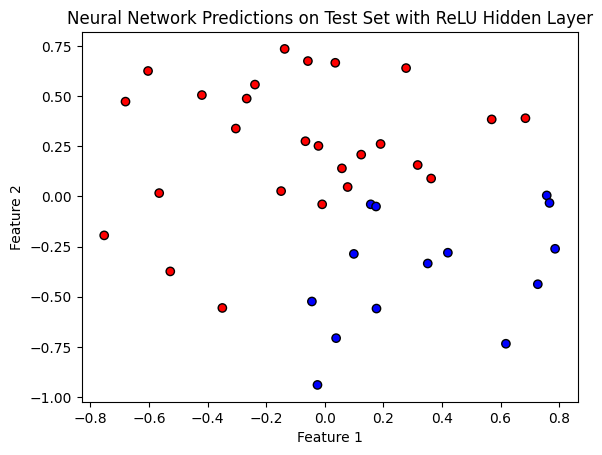

In [39]:
# Define activation functions
def relu(x):
    """ ReLU activation function """
    return np.maximum(0, x)

def relu_derivative(x):
    """ Derivative of the ReLU function, used for backpropagation """
    return (x > 0).astype(float)  # gradient is 1 for x > 0, otherwise 0

def sigmoid(x):
    """ Sigmoid activation function for output layer """
    return 1 / (1 + np.exp(-x))

def sigmoid_derivative(x):
    """ Derivative of the sigmoid function, used for backpropagation """
    return x * (1 - x)

# Generate a synthetic dataset similar to spiral_data
def generate_synthetic_data(samples=100):
    """ Generates a synthetic dataset with two features and binary labels """
    np.random.seed(42)
    X = np.random.randn(samples, 2)  # generate two random features
    y = (X[:, 0] * X[:, 1] > 0).astype(int).reshape(-1, 1)  # assign labels based on feature product
    return X, y

# Generate dataset
X, y = generate_synthetic_data(samples=100)

# Initialise weights and biases with random values
input_size = 2   # two input values (features)
hidden_size = 4  # hidden layer with 4 neurons
output_size = 1  # single output neuron (binary classification)

np.random.seed(42)
W1 = np.random.randn(input_size, hidden_size)  # weights from input to hidden layer
b1 = np.zeros((1, hidden_size))  # bias for hidden layer
W2 = np.random.randn(hidden_size, output_size)  # weights from hidden to output layer
b2 = np.zeros((1, output_size))  # bias for output layer

# Hyperparameters
learning_rate = 0.01  # defines how much the weights are adjusted during training
epochs = 5000  # number of times the network sees the entire dataset


# Run the training process
for epoch in range(epochs):
    # Forward pass on training set
    Z1 = np.dot(X_train, W1) + b1
    A1 = relu(Z1)
    Z2 = np.dot(A1, W2) + b2
    A2 = sigmoid(Z2)

    # Compute loss
    loss = -np.mean(y_train * np.log(A2) + (1 - y_train) * np.log(1 - A2))

    # Backpropagation
    dA2 = A2 - y_train
    dZ2 = dA2 * sigmoid_derivative(A2)
    dW2 = np.dot(A1.T, dZ2) / len(X_train)
    db2 = np.sum(dZ2, axis=0, keepdims=True) / len(X_train)

    dA1 = np.dot(dZ2, W2.T)
    dZ1 = dA1 * relu_derivative(Z1)
    dW1 = np.dot(X_train.T, dZ1) / len(X_train)
    db1 = np.sum(dZ1, axis=0, keepdims=True) / len(X_train)

    # Update weights and biases
    W2 -= learning_rate * dW2
    b2 -= learning_rate * db2
    W1 -= learning_rate * dW1
    b1 -= learning_rate * db1

    # Print loss every 1000 epochs to monitor progress
    if epoch % 1000 == 0:
        print(f"Epoch {epoch}, Loss: {loss:.4f}")

# Evaluate Model on Test Data
Z1_test = np.dot(X_test, W1) + b1
A1_test = relu(Z1_test)
Z2_test = np.dot(A1_test, W2) + b2
A2_test = sigmoid(Z2_test)

# Convert probabilities to binary predictions
predictions_test = (A2_test > 0.5).astype(int)

# Plot dataset with predictions on the test set
plt.scatter(X_test[:, 0], X_test[:, 1], c=predictions_test.flatten(), cmap="bwr", edgecolors="k")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.title("Neural Network Predictions on Test Set with ReLU Hidden Layer")
plt.show()


In [40]:
# Print evaluation metrics
print("\nNeural Network Evaluation on Test Data:")
print(classification_report(y_test, predictions_test))



Neural Network Evaluation on Test Data:
              precision    recall  f1-score   support

           0       0.64      0.43      0.51        21
           1       0.54      0.74      0.62        19

    accuracy                           0.57        40
   macro avg       0.59      0.58      0.57        40
weighted avg       0.59      0.57      0.57        40



<br>

### Analysis of the Simple Neural Network Implementation

1. Training Loss Trend

| Epoch  | Loss |
|--------|------|
| **0**  | **0.7611** |
| **1000** | **0.7217** |
| **2000** | **0.7029** |
| **3000** | **0.6922** |
| **4000** | **0.6845** |

- Observations:
  - Loss is decreasing, but very slowly
  - Loss is still high (~0.68), indicating the model has not learned well
  - This suggests underfitting, meaning the model is not complex enough or has not trained for enough epochs

2. Accuracy and Performance on Test Data

| Metric  | Value |
|---------|------|
| **Accuracy** | **57%** |
| **Macro F1-score** | **57%** |

- The model's accuracy is 57%, which is barely better than random guessing (50% for binary classification)
  - This confirms the model is not learning patterns well

3. Precision, Recall, and F1-Score

| Class | Precision | Recall | F1-Score | Support |
|-------|-----------|--------|----------|---------|
| **0** | **64%** | **43%** | **51%** | **21** |
| **1** | **54%** | **74%** | **62%** | **19** |

- Observations:
  - Class 0 (negative) has low recall (43%)
    - The model is failing to correctly identify many actual class 0 samples
  - Class 1 (positive) has higher recall (74%)
    - The model predicts more class 1s correctly, but with lower precision

- Possible Issues:
  1. Model is predicting too many class 1s (positive cases), likely due to imbalance in gradient updates
  2. Decision boundary may be poorly defined, leading to frequent misclassification
  3. Training might need a more powerful network to capture better features

4. Key Issues & Fixes

  - Underfitting (Model not learning enough)
    - The accuracy suggests the model has not captured meaningful patterns
      - Can increase training epochs or adjust the learning rate

  - Gradient updates may be weak
    - The loss is not reducing significantly, which suggests poor gradient updates
      - Can try learning rate adjustments
      
  - Too few hidden neurons
    - A 4-neuron hidden layer might not be enough to model the data complexity
      - Can increase hidden neurons
  
  - Potential data overlap
    - If classes are too mixed, the model struggles to separate them
      - Can visualise decision boundaries and apply feature scaling if necessary




---